Multi-level Perturbed Unit Gradient Descent, MPUGD

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data  import Subset, DataLoader

import torchvision
import torchvision.transforms as transforms
from types import SimpleNamespace 
import matplotlib.pyplot  as plt
import numpy as np 

from optimizers import *
from upanets import UPANets
from torchsummary import summary
import time, copy,timm
import json
import random 
import os
from train import *

e:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
args = SimpleNamespace(
    datasets='cifar_100',
    batch_size = 500,
    seed = 42,
    lr=0.1, 
    momentum=0.9,
    wd = 0.0005,
    blocks = 1,
    filters = 16,
    epochs = 400,
    start_epochs = 8
    )

In [3]:
def set_all_seeds(seed=42):
    # Python原生随机 
    random.seed(seed) 
    # NumPy随机 
    np.random.seed(seed) 
    # PyTorch随机 
    torch.manual_seed(seed) 
    # CUDA随机（GPU相关）
    torch.cuda.manual_seed_all(seed) 
    # CUDNN确定性模式 
    torch.backends.cudnn.deterministic  = True 
    torch.backends.cudnn.benchmark  = False 
 
set_all_seeds(args.seed)  

In [4]:
print(device)

cuda


In [5]:
img_size = 32 # default image size for Cifar-10
im_dimention = 32
cifar_10_mean = [0.4914, 0.4822, 0.4465] 
cifar_10_std = [0.2023, 0.1994, 0.2010]
cifar_100_mean = [0.5071, 0.4867, 0.4408]
cifar_100_std = [0.2673, 0.2564, 0.2762]

if args.datasets == 'cifar_10':
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.RandomRotation(15,),
            transforms.RandomCrop(im_dimention),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
            # transforms.Lambda(lambda x: x.to(torch.float16))    # 最终输出FP16
        ]),
        # 'valid': transforms.Compose([
        #     transforms.Resize((im_dimention,im_dimention)),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        # ]),
        'test': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
    }
 
    full_trainset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=False, download=True, transform=data_transforms['test'])
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    Num_class = 10

if args.datasets == 'cifar_100':
    data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    # 'valid': transforms.Compose([
    #     transforms.Resize((im_dimention,im_dimention)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    # ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    }
    full_trainset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=False, download=True, transform=data_transforms['test'])
    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False,sampler=torch.utils.data.SequentialSampler(testset),  num_workers=0)
    Num_class = 100

# # 获取所有样本的标签 
# labels = [full_trainset[i][1] for i in range(len(full_trainset))]

# # 分层划分（stratify参数确保比例）
# train_idx, val_idx = train_test_split(
#     range(len(full_trainset)),
#     test_size=0.2,
#     shuffle=True,
#     stratify=labels,
#     random_state=args.seed  
# )

# train_data = np.stack([full_trainset.data[i]  for i in train_idx]) 
# train_targets = [full_trainset.targets[i] for i in train_idx] 
# val_data = np.stack([full_trainset.data[i]  for i in val_idx]) 
# val_targets = [full_trainset.targets[i] for i in val_idx] 

# valset = full_trainset
# valset.data = val_data
# valset.targets = val_targets
# valset.transform = data_transforms['valid']

# trainset = copy.deepcopy(valset)
# trainset.data = train_data
# trainset.targets = train_targets
# trainset.transform = data_transforms['train']

# trainloader = {
#     'train':DataLoader(
#     trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(trainset), num_workers=0),
#     'valid':DataLoader(
#     valset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(valset), num_workers=0)}

# dataset_sizes = {
#     'train': len(trainset),
#     'valid': len(valset),            
                #  }

trainloader = {
    'train':DataLoader(
    full_trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(full_trainset), num_workers=0),
    'valid':testloader
}

dataset_sizes = {
    'train': len(full_trainset),
    'valid': len(testset),      
}
print(dataset_sizes)


100%|██████████| 169M/169M [2:08:27<00:00, 21.9kB/s]   


{'train': 50000, 'valid': 10000}


In [6]:
print(timm.list_models('*vit_tiny_patch16_224*')) 

['vit_tiny_patch16_224']


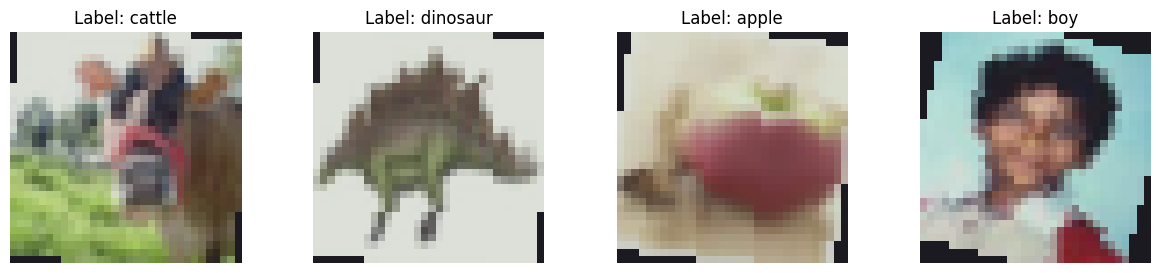

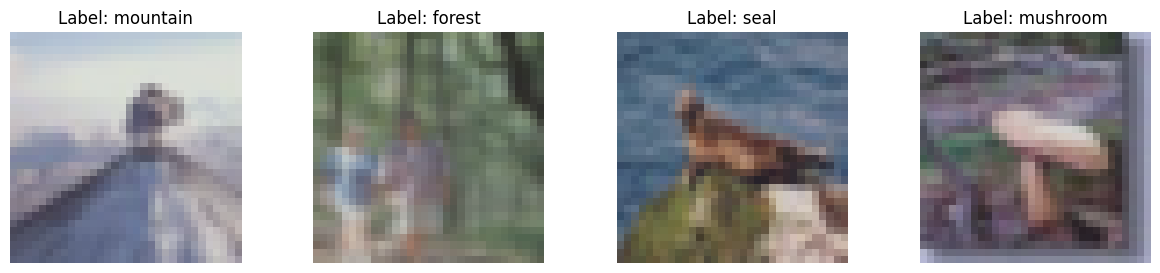

In [7]:
# from torchvision.transforms.functional  import to_pil_image 
# 反归一化转换（需与transform中的参数对应）
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)
 
def show_images(loader, num_images=4):
    # 获取一个batch的数据 
    # images, labels = next(iter(loader))
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx == 0:  # 只取第一个batch 
            break 

    # 创建子图 
    fig, axes = plt.subplots(1,  num_images, figsize=(15, 3))
    
    for i in range(num_images):
        # 反归一化+通道顺序调整 
        img = inv_normalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img,  0, 1)  # 处理浮点误差 
        
        # 显示图像及标签 
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {full_trainset.classes[labels[i]]}") 
        axes[i].axis('off')
    
    plt.show() 
 
show_images(trainloader['train'])
show_images(testloader)

In [8]:
model_path = "./model/" + args.datasets + "/benckmark.pth"
if os.path.exists(model_path):
    net_benckmark_data = torch.load(model_path,  map_location='cpu')
    benckmark_state_dict = net_benckmark_data['model_state_dict'] 
else:
    net_benchmark = UPANets(args.filters, Num_class, args.blocks, img_size)
    torch.save({
        'model_state_dict': net_benchmark.state_dict()
    }, model_path)
    benckmark_state_dict = net_benchmark.state_dict()

def tensor_to_serializable(obj):
    if isinstance(obj, (np.float32,  np.float64)):   # 处理NumPy浮点数
        return float(obj)
    elif isinstance(obj, np.integer):               # 处理NumPy整数 
        return int(obj)
    elif isinstance(obj, torch.Tensor):            # 处理PyTorch Tensor 
        return obj.item()  if obj.numel()  == 1 else obj.tolist() 
    elif isinstance(obj, (np.ndarray)):             # 处理NumPy数组 
        return obj.tolist() 
    elif hasattr(obj, '__dict__'):                 # 处理自定义对象（可选）
        return obj.__dict__
    return obj 


In [9]:
# net_pugdt_delta = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_delta.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_delta.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_delta = torch.nn.DataParallel(net_pugdt_delta)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_delta.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_delta, metricst_delta = train_model_timing_delta(net_pugdt_delta, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.01, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_delta.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_delta,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [10]:
# net_pugdt_var = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_var.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_var.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_var = torch.nn.DataParallel(net_pugdt_var)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_var.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_var, metricst_var = train_model_timing_var(net_pugdt_var, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.015, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_var.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_var,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [11]:
# net = UPANets(args.filters, Num_class, args.blocks, img_size)
# net.load_state_dict(copy.deepcopy(benckmark_state_dict))

# criterion = torch.nn.CrossEntropyLoss()

# net.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True

# optimizer = optim.SGD(net.parameters(),
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net, metrics_org = train_model_org(net, criterion, optimizer, scheduler, args.epochs * 2, trainloader, device, dataset_sizes) 

# # 保存模型架构+参数+优化器状态（完整恢复训练）
# model_path = "./model/"+args.datasets+"/org" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/org_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics_org, f, default=tensor_to_serializable, ensure_ascii=False, indent=4)
 
# # 加载 

# # checkpoint = torch.load('full_model_checkpoint.pth',  map_location='cpu')  # 先加载到CPU避免设备冲突 
# # 模型结构需提前定义（需与保存时一致）
# # model = YourModelClass()  
# # model.load_state_dict(checkpoint['model_state_dict']) 
 
# # # 恢复优化器和训练状态 
# # optimizer = torch.optim.Adam(model.parameters())  
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
# # with open('data.json',  'r', encoding='utf-8') as f:
# #     loaded_dict = json.load(f) 


# # summary(net, (3, img_size, img_size))


In [ ]:
# net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.2, 
#                 max_beta = 2.0, 
#                 method = 'sin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.69257998466492
Epoch 1/399
42.74359893798828
Epoch 2/399
42.64279508590698
Epoch 3/399
42.87194275856018
Epoch 4/399
42.753376483917236
Epoch 5/399
42.73880338668823
Epoch 6/399
42.66704177856445
Epoch 7/399
42.76157355308533
Epoch 8/399
42.69153928756714
Epoch 9/399
42.7905650138855
Epoch 10/399
42.90798807144165
Epoch 11/399
42.7640278339386
Epoch 12/399
42.671937227249146
Epoch 13/399
42.69559407234192
Epoch 14/399
42.71925902366638
Epoch 15/399
42.650216817855835
Epoch 16/399
42.62173652648926
Epoch 17/399
42.919633865356445
Epoch 18/399
42.87660312652588
Epoch 19/399
42.881592988967896
Epoch 20/399
42.88398575782776
Epoch 21/399
42.72192978858948
Epoch 22/399
42.76211142539978
Epoch 23/399
42.805020332336426
Epoch 24/399
42.80980110168457
Epoch 25/399
42.96423053741455
Epoch 26/399
42.82155251502991
Epoch 27/399
42.869399309158325
Epoch 28/399
42.919581174850464
Epoch 29/399
42.81159281730652
Epoch 30/399
42.78499984741211
Epoch 31/399
42.852017641067505
Epoch 32/39

In [ ]:
# net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 1.0, 
#                 max_beta = 2.0, 
#                 method = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_cos, metricsr_sin = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.508570432662964
Epoch 1/399
42.51394438743591
Epoch 2/399
42.541924238204956
Epoch 3/399
42.69462513923645
Epoch 4/399
42.519649267196655
Epoch 5/399
42.46732950210571
Epoch 6/399
42.56809616088867
Epoch 7/399
42.52569341659546
Epoch 8/399
42.47029232978821
Epoch 9/399
42.50559997558594
Epoch 10/399
42.65840268135071
Epoch 11/399
42.49375033378601
Epoch 12/399
42.43258786201477
Epoch 13/399
42.50002884864807
Epoch 14/399
42.50637912750244
Epoch 15/399
42.4919376373291
Epoch 16/399
42.435163736343384
Epoch 17/399
42.59052634239197
Epoch 18/399
42.43811011314392
Epoch 19/399
42.438355684280396
Epoch 20/399
42.42369198799133
Epoch 21/399
42.41685724258423
Epoch 22/399
42.41255259513855
Epoch 23/399
42.37650680541992
Epoch 24/399
42.374326944351196
Epoch 25/399
42.5458550453186
Epoch 26/399
42.37993907928467
Epoch 27/399
42.377089738845825
Epoch 28/399
42.40745568275452
Epoch 29/399
42.343273878097534
Epoch 30/399
42.34060001373291
Epoch 31/399
42.3425030708313
Epoch 32/399


In [ ]:
# net_pugds_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_cos = torch.nn.DataParallel(net_pugds_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 1.2, 
#                 max_beta = 3.0,
#                 method = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugds_cos, metricss_cos = train_model_alpha(net_pugds_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
43.06178283691406
Epoch 1/399
42.78677725791931
Epoch 2/399
42.572144985198975
Epoch 3/399
42.6160523891449
Epoch 4/399
42.539971351623535
Epoch 5/399
42.43129873275757
Epoch 6/399
42.49750089645386
Epoch 7/399
42.903318881988525
Epoch 8/399
42.61418437957764
Epoch 9/399
42.7950758934021
Epoch 10/399
42.57585906982422
Epoch 11/399
42.676628828048706
Epoch 12/399
42.71961307525635
Epoch 13/399
42.72213864326477
Epoch 14/399
42.961575508117676
Epoch 15/399
42.428109645843506
Epoch 16/399
42.49834156036377
Epoch 17/399
42.42474889755249
Epoch 18/399
42.32669949531555
Epoch 19/399
42.37220621109009
Epoch 20/399
42.29598140716553
Epoch 21/399
42.63920259475708
Epoch 22/399
42.35221600532532
Epoch 23/399
42.37447786331177
Epoch 24/399
42.76771330833435
Epoch 25/399
42.736692667007446
Epoch 26/399
42.65176343917847
Epoch 27/399
42.60490012168884
Epoch 28/399
42.939117193222046
Epoch 29/399
42.487131118774414
Epoch 30/399
42.6738440990448
Epoch 31/399
42.61066722869873
Epoch 32/399

In [ ]:
# net_pugds_sin = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_sin = torch.nn.DataParallel(net_pugds_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 1.8, 
#                 max_beta = 2.0,
#                 method = 'sin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugds_sin, metricss_sin = train_model_alpha(net_pugds_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
43.09069609642029
Epoch 1/399
42.78116202354431
Epoch 2/399
42.773298025131226
Epoch 3/399
42.76937747001648
Epoch 4/399
42.79592537879944
Epoch 5/399
42.71406173706055
Epoch 6/399
42.603665351867676
Epoch 7/399
42.78681564331055
Epoch 8/399
42.513774394989014
Epoch 9/399
42.59732532501221
Epoch 10/399
42.67681097984314
Epoch 11/399
42.78083515167236
Epoch 12/399
42.80828857421875
Epoch 13/399
42.72456431388855
Epoch 14/399
42.99508714675903
Epoch 15/399
42.9476318359375
Epoch 16/399
43.124513387680054
Epoch 17/399
43.024787187576294
Epoch 18/399
43.037596225738525
Epoch 19/399
42.928133964538574
Epoch 20/399
43.139808893203735
Epoch 21/399
43.155784130096436
Epoch 22/399
43.03608512878418
Epoch 23/399
43.023193359375
Epoch 24/399
43.02739119529724
Epoch 25/399
43.13265061378479
Epoch 26/399
43.11766862869263
Epoch 27/399
42.98157238960266
Epoch 28/399
43.016579389572144
Epoch 29/399
43.38964819908142
Epoch 30/399
42.94228482246399
Epoch 31/399
43.102339029312134
Epoch 32/3

In [ ]:
# net_pugd = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugd.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugd.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugd)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDX(net_pugd.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugd, metrics0 = train_model(net_pugd, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugd" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugd.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugd_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
43.0082311630249
Epoch 1/399
42.809155225753784
Epoch 2/399
42.85860252380371
Epoch 3/399
42.892414808273315
Epoch 4/399
42.83387517929077
Epoch 5/399
42.80202388763428
Epoch 6/399
43.03037881851196
Epoch 7/399
42.8369300365448
Epoch 8/399
42.88224720954895
Epoch 9/399
42.91175818443298
Epoch 10/399
42.915849447250366
Epoch 11/399
42.975785970687866
Epoch 12/399
42.8978009223938
Epoch 13/399
42.89608192443848
Epoch 14/399
42.84656596183777
Epoch 15/399
42.848140478134155
Epoch 16/399
42.864821672439575
Epoch 17/399
42.99965524673462
Epoch 18/399
42.82561111450195
Epoch 19/399
42.86124849319458
Epoch 20/399
42.821730613708496
Epoch 21/399
42.808387994766235
Epoch 22/399
42.84558415412903
Epoch 23/399
42.96629238128662
Epoch 24/399
42.763208627700806
Epoch 25/399
42.81470990180969
Epoch 26/399
42.80698299407959
Epoch 27/399
42.93968319892883
Epoch 28/399
42.87810659408569
Epoch 29/399
42.97954821586609
Epoch 30/399
42.83175873756409
Epoch 31/399
42.815828800201416
Epoch 32/39

In [ ]:
# net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.3, 
#                 max_beta = 1, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdr_cos, metricsr_cos = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
43.04285907745361
Epoch 1/399
42.855143785476685
Epoch 2/399
42.81504201889038
Epoch 3/399
42.85459661483765
Epoch 4/399
42.860286474227905
Epoch 5/399
42.84706997871399
Epoch 6/399
42.876978397369385
Epoch 7/399
42.86351680755615
Epoch 8/399
43.056620597839355
Epoch 9/399
42.8349769115448
Epoch 10/399
42.84726595878601
Epoch 11/399
42.80242943763733
Epoch 12/399
42.7547709941864
Epoch 13/399
42.811803579330444
Epoch 14/399
42.80899357795715
Epoch 15/399
42.857101917266846
Epoch 16/399
42.80067253112793
Epoch 17/399
42.72907042503357
Epoch 18/399
42.779261112213135
Epoch 19/399
42.903149127960205
Epoch 20/399
42.826558113098145
Epoch 21/399
42.766003370285034
Epoch 22/399
42.91547632217407
Epoch 23/399
42.789761781692505
Epoch 24/399
42.808955669403076
Epoch 25/399
42.81203103065491
Epoch 26/399
42.80989336967468
Epoch 27/399
42.80807375907898
Epoch 28/399
42.870145320892334
Epoch 29/399
42.975016593933105
Epoch 30/399
42.869850873947144
Epoch 31/399
42.849140882492065
Epoc

In [ ]:
# net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.1, 
#                 max_beta = 1, 
#                 method = 'isin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.909780502319336
Epoch 1/399
42.842941999435425
Epoch 2/399
42.753029346466064
Epoch 3/399
42.81730914115906
Epoch 4/399
42.76830768585205
Epoch 5/399
42.99929451942444
Epoch 6/399
42.817275285720825
Epoch 7/399
42.87195873260498
Epoch 8/399
42.82991147041321
Epoch 9/399
42.93315529823303
Epoch 10/399
42.8634397983551
Epoch 11/399
42.88214111328125
Epoch 12/399
42.998069286346436
Epoch 13/399
42.91105079650879
Epoch 14/399
42.95466446876526
Epoch 15/399
42.90417957305908
Epoch 16/399
42.892874240875244
Epoch 17/399
42.848880767822266
Epoch 18/399
42.93356370925903
Epoch 19/399
43.040442943573
Epoch 20/399
42.93187928199768
Epoch 21/399
42.916643381118774
Epoch 22/399
42.87760877609253
Epoch 23/399
42.84321308135986
Epoch 24/399
42.89389491081238
Epoch 25/399
42.78952646255493
Epoch 26/399
42.807770013809204
Epoch 27/399
42.712032318115234
Epoch 28/399
42.74294900894165
Epoch 29/399
42.72605776786804
Epoch 30/399
42.76972579956055
Epoch 31/399
42.66262221336365
Epoch 32/39

In [ ]:
net_pugds_icos = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugds_icos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugds_icos.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    net_pugds_icos = torch.nn.DataParallel(net_pugds_icos)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXS(net_pugds_icos.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.48, 
                max_beta = 4.0, 
                method = 'icos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

net_pugds_icos, metricss_icos = train_model_alpha(net_pugds_icos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugds_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugds_icos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugds_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricss_icos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
43.17793154716492
Epoch 1/399
42.79453635215759
Epoch 2/399
42.8968243598938
Epoch 3/399
43.03336000442505
Epoch 4/399
43.00428915023804
Epoch 5/399
43.08159327507019
Epoch 6/399
43.05025005340576
Epoch 7/399
43.29147791862488
Epoch 8/399
42.960460901260376
Epoch 9/399
43.12692880630493
Epoch 10/399
43.10013699531555
Epoch 11/399
43.106147050857544
Epoch 12/399
43.049407958984375
Epoch 13/399
43.09846591949463
Epoch 14/399
42.664785861968994
Epoch 15/399
42.866944313049316
Epoch 16/399
42.54526495933533
Epoch 17/399
42.47765874862671
Epoch 18/399
42.68008995056152
Epoch 19/399
42.466111183166504
Epoch 20/399
42.678207874298096
Epoch 21/399
42.45880603790283
Epoch 22/399
42.64660573005676
Epoch 23/399
42.49882960319519
Epoch 24/399
42.44508719444275
Epoch 25/399
42.46719026565552
Epoch 26/399
42.28192687034607
Epoch 27/399
42.510653257369995
Epoch 28/399
42.36039996147156
Epoch 29/399
42.70844554901123
Epoch 30/399
42.390923738479614
Epoch 31/399
42.29704523086548
Epoch 32/3

In [ ]:
# net_pugds_icos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_icos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_icos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_icos = torch.nn.DataParallel(net_pugds_icos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_icos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 3.0, 
#                 max_beta = 4.0, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugds_icos, metricss_icos = train_model_alpha(net_pugds_icos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_icos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_icos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.72441911697388
Epoch 1/399
42.60701370239258
Epoch 2/399
42.492568016052246
Epoch 3/399
42.417994022369385
Epoch 4/399
42.472524642944336
Epoch 5/399
42.60459280014038
Epoch 6/399
42.46808457374573
Epoch 7/399
42.462626218795776
Epoch 8/399
42.837891817092896
Epoch 9/399
43.01931667327881
Epoch 10/399
42.7667019367218
Epoch 11/399
42.59381580352783
Epoch 12/399
42.80826950073242
Epoch 13/399
42.89291191101074
Epoch 14/399
42.748324155807495
Epoch 15/399
42.92631793022156
Epoch 16/399
42.76065802574158
Epoch 17/399
42.805119037628174
Epoch 18/399
42.63368606567383
Epoch 19/399
42.453234910964966
Epoch 20/399
42.563608169555664
Epoch 21/399
42.47196865081787
Epoch 22/399
42.483593225479126
Epoch 23/399
42.64910268783569
Epoch 24/399
42.65200090408325
Epoch 25/399
42.77142572402954
Epoch 26/399
42.6257107257843
Epoch 27/399
42.490060329437256
Epoch 28/399
42.686830043792725
Epoch 29/399
42.63574171066284
Epoch 30/399
42.646960973739624
Epoch 31/399
42.590752363204956
Epoch 

In [ ]:
# net_pugds_isin = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_isin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_isin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_isin = torch.nn.DataParallel(net_pugds_isin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_isin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.1, 
#                 max_beta = 2,
#                 method = 'isin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugds_isin, metricss_isin = train_model_alpha(net_pugds_isin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_isin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_isin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.97323298454285
Epoch 1/399
42.64492416381836
Epoch 2/399
42.73261094093323
Epoch 3/399
42.66949772834778
Epoch 4/399
42.64363741874695
Epoch 5/399
42.65336894989014
Epoch 6/399
42.65363574028015
Epoch 7/399
42.988038539886475
Epoch 8/399
42.642441511154175
Epoch 9/399
42.59726881980896
Epoch 10/399
42.64861726760864
Epoch 11/399
42.63712668418884
Epoch 12/399
42.55338096618652
Epoch 13/399
42.59806537628174
Epoch 14/399
42.84696316719055
Epoch 15/399
42.675779581069946
Epoch 16/399
42.70725965499878
Epoch 17/399
42.75239586830139
Epoch 18/399
42.833563804626465
Epoch 19/399
42.87092351913452
Epoch 20/399
42.83858346939087
Epoch 21/399
42.83780574798584
Epoch 22/399
43.03915739059448
Epoch 23/399
42.87589907646179
Epoch 24/399
42.849788665771484
Epoch 25/399
42.8853702545166
Epoch 26/399
42.96630573272705
Epoch 27/399
42.88853621482849
Epoch 28/399
43.00564765930176
Epoch 29/399
43.0901517868042
Epoch 30/399
42.940428733825684
Epoch 31/399
42.894660234451294
Epoch 32/399


In [ ]:
# net_pugdrs = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdrs.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdrs.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdrs = torch.nn.DataParallel(net_pugdrs)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXRS(net_pugdrs.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta_r = 0.1, 
#                 max_beta_r = 2, 
#                 method_r = 'isin',
#                 min_beta_s = 0.5, 
#                 max_beta_s = 1.0,
#                 method_s = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdrs, metricsrs = train_model_alpha(net_pugdrs, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdrs.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsrs,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [ ]:
# net_pugdrs = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdrs.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdrs.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdrs = torch.nn.DataParallel(net_pugdrs)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXRS(net_pugdrs.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta_r = 0.1, 
#                 max_beta_r = 2, 
#                 method_r = 'icos',
#                 min_beta_s = 0.5, 
#                 max_beta_s = 1.0,
#                 method_s = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdrs, metricsrs = train_model_alpha(net_pugdrs, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdrs.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsrs,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [23]:
# VGG-16 ResNet-18 DenseNet-121* growth rate in 16 UPANet-16 Overall Average

In [24]:
# ## finetune

# from transformers import ViTForImageClassification, DeiTForImageClassification 
 
# # 加载预训练模型 
# vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=10, ignore_mismatched_sizes=True, device_map="auto", resume_download=True) 
# deit_model = DeiTForImageClassification.from_pretrained("facebook/deit-base-patch16-224", num_labels=10, ignore_mismatched_sizes=True, device_map="auto", resume_download=True) 



In [25]:
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
#     optimizer,  # 绑定的优化器对象 
#     mode='max',  # 监测指标模式 
#     factor=0.5,  # 学习率衰减系数 
#     patience=3   # 等待周期数 
# )
# for name, param in vit_model.named_parameters(): 
#     if 'encoder.layer.0'  in name:  # 冻结前N层 
#         param.requires_grad  = False 
# # 修改分类头以适应CIFAR-10的10类 
# vit_model.classifier  = torch.nn.Linear(vit_model.config.hidden_size,  10)
# deit_model.classifier  = torch.nn.Linear(deit_model.config.hidden_size,  10)

In [26]:
# print(new_head.__dict__)
# print(vars(new_head))
# import optimizers
# import importlib 
# importlib.reload(optimizers)   
# from optimizers import *

In [27]:
# model_ft2 = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=Num_class)
# original_head = model_ft2.classifier   # MobileNetV3的分类头名为classifier 
# new_head = nn.Linear(original_head.in_features,  Num_class)
# model_ft2 = model_ft2.to(device)
# criterion = torch.nn.CrossEntropyLoss()


# base_optimizer2 = optim.SGD
# optimizer2 = PUGD2(model_ft2.parameters(),
#                  base_optimizer2,
#                  lr=args.lr,
#                  momentum=args.momentum,
#                  weight_decay=args.wd,
#                  )


# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

# model_ft2 = train_model2(model_ft2, criterion, optimizer2, exp_lr_scheduler, num_epochs=20) 